In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

In [4]:
targetDir = "../data/output/d2/Result/"
speedDir = "../data/output/d2/Speed/"
brakeDir = "../data/output/d2/Brake/"
accelDIr = "../data/output/d2/Accel/"
steeringPositiveDir = "../data/output/d2/SteeringPositive/"
steeringNegativeDir = "../data/output/d2/SteeringNegative/"
segmentDir = "../data/output/d2/SegmentSize/"

In [5]:
df1 = pd.read_csv(speedDir + "result.csv")
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(segmentDir + "result.csv")
df6.columns = [["id", "segmentSize"]]

In [6]:
df = pd.merge(pd.merge(pd.merge(pd.merge(df1, df2, on="id"), df3, on="id"), df4, on="id"), df5, on="id")
df = pd.merge(df, df6, on="id")
gridSize = len(df)

In [7]:
noisyRows = [1568, 626, 1252, 662, 625, 1332, 624, 623, 663, 662, 711, 751]
df = df.drop(df.index[noisyRows])

In [8]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['stop'] > 0]
mf = mf[["red", "brake", "accel", "steeringPositive",  "steeringNegative", "segmentSize"]]
mf.columns = ["red", "brake", "accel", "steeringPositive",  "steeringNegative", "segmentSize"]

# Summation of all statuses and calculate risk

In [9]:
rows = mf.as_matrix()
mf["sum"] = [np.sum(rows[i][:-1]) for i in range(len(rows))]

In [10]:
mf["risk"] = mf["sum"] / mf["segmentSize"]

In [11]:
mf.describe()

,red,brake,accel,steeringPositive,steeringNegative,segmentSize,sum,risk
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,26.443820,43.539326,64.213483,46.887640,74.511236,387.415730,255.595506,0.632504
std,43.534254,58.858454,74.016867,104.210233,206.214858,443.847694,339.807946,0.341437
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,12.250000,0.000000,0.000000,116.750000,56.000000,0.367983
50%,5.000000,20.000000,28.000000,1.000000,2.000000,276.500000,153.000000,0.574862
75%,31.000000,62.000000,99.000000,26.000000,35.750000,466.500000,272.000000,0.794653
max,188.000000,313.000000,383.000000,521.000000,1455.000000,2529.000000,1872.000000,1.419142


In [13]:
top5 = mf[mf["sum"] > 40].sort_values("risk", ascending=False)[:5]
top5 = top5[["red", "brake", "accel", "steeringNegative", "steeringPositive", "sum"]]

for key in top5.columns:
    if key == "sum":
        continue
    top5[key] = top5[key] / top5["sum"]

top5 = top5[["red", "brake", "accel", "steeringNegative", "steeringPositive"]]
top5Index = top5.index

In [14]:
top5Index

Int64Index([1337, 632, 1289, 182, 869], dtype='int64')

# Save

In [15]:
pred = zip(mf.index, mf["risk"])
result = np.zeros(gridSize)

for index, risk in pred:
    result[index] = risk
    
np.savetxt(targetDir + "risks.csv", result, delimiter=",", fmt="%f")

# Risk graph order by index

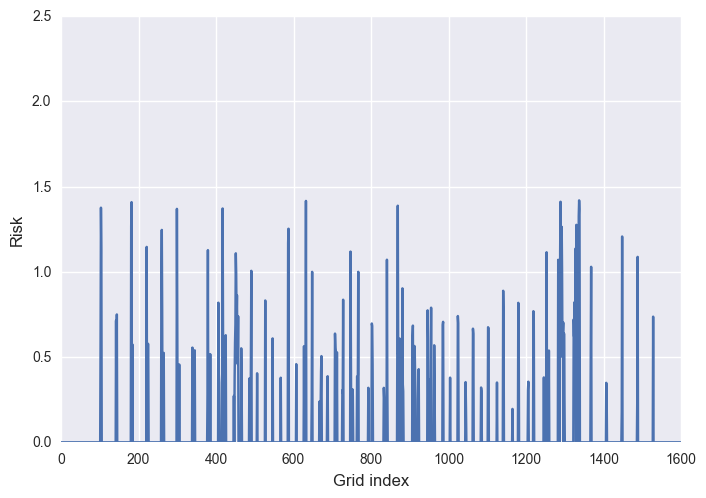

In [16]:
plt.plot(result)
plt.ylim(0, 2.5)
plt.xlabel("Grid index", size="medium")
plt.ylabel("Risk", size="medium")